________________
# Sky RMS test on HST images

Written by Laura Prichard, October 2019. Updated for Python 3.7 August 2020.

Takes drizzled _Hubble space Telescope_ (HST) images (with `build=True` in `Astrodrizzle` from [DrizzlePac](https://www.stsci.edu/scientific-community/software/drizzlepac.html)) as inputs. Code creates a segmentation map with `photutils`, then measures the root-mean-squared (RMS) of the sky background within randomly placed apertures where there are no objects. Then plots a histogram, Gaussian of distribution, and averages of the RMS measurements. With additional user inputs, can determine a limiting magnitude of the image within a user-defined aperture size.

**0. Import packages**

In [1]:
import numpy as np
import random
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from scipy.stats import norm
from photutils import detect_sources, detect_threshold
from astropy.convolution import Gaussian2DKernel, Tophat2DKernel
from astropy.stats import gaussian_fwhm_to_sigma, sigma_clipped_stats
from astropy.visualization import SqrtStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize

%matplotlib inline

**1. Read in image**

An example drizzle of Wide Field Camera 3 (WFC3)/F336W `*flc.fits` from [MAST](https://archive.stsci.edu/) is in this directory (`F336W_drc.fits`). This was made with `build=True`, so the data and error maps are in different extensions.

In [2]:
# ---------------------------------------
# REQUIRED USER INPUT

# File path to drizzled output image made with build=True
file = './F336W_drc.fits'
# ---------------------------------------

# Open the drizzled image
drz = fits.open(file)

# Get header
hdr = drz[0].header

# Read in data
dat = drz[1].data

# Read in IVM/ERR maps
ivm = drz[2].data

**2. Make segmentation maps with `photutils`**

Play with the kernel width (`sigma`), size (`x_size`, `y_size`), type (`kern`) for smoothing the image. The threshold (`snr`) and number of pixels (`npix`) will determine how many objects are identified in the image.

In [3]:
def make_seg_map(data, sigma=3.0, x_size=3, y_size=3, kern='gauss', snr=3.0, npix=3):
    """For input science image data, create a kernel with user input size (x_size,y_size),
    width (sigma) and type (kern, options 'gauss' or 'tophat'). Set a threshold using 
    photutils.detect_threshold and user input S/N (snr). Create a segmentation map of 
    image with the threshold and kernel as inputs, and the number of continuous pixels 
    for an object to be considered real (npix)."""
    
    # Create a kernel
    # sigma = sig * gaussian_fwhm_to_sigma    # If providing a FWHM instead of sigma, FWHM = 3.
    if kern=='gauss': kernel = Gaussian2DKernel(sigma, x_size=x_size, y_size=y_size)
    elif kern=='tophat': kernel = Tophat2DKernel(sigma*2.5, x_size=int(x_size*3), y_size=int(y_size*3))
    else: print("ERROR: Kernel should be either 'gauss' or 'tophat'")
    kernel.normalize()

    # Determine a detection threshold
    threshold = detect_threshold(data, nsigma=snr)
    
    # Create a segemenation map
    segm = detect_sources(data, threshold, npixels=npix, filter_kernel=kernel)
    return segm, kernel

In [4]:
# Create a segmenation map of the image
segm, kern = make_seg_map(dat, sigma=3.0, snr=3.0, npix=20)

In [5]:
# Count the number of sources
print('Sources in image: {}'.format(segm.nlabels))

Sources in image: 2319


**3. Plot & check image, segmentation maps, and IVM/ERR array**

Check to see if the segmenation map seems to be picking up real objects by comparing it with the image. Check the footprint of the IVM image, this shows where data are without relying on NaNs or zeros in the image itself which can appear throughout.

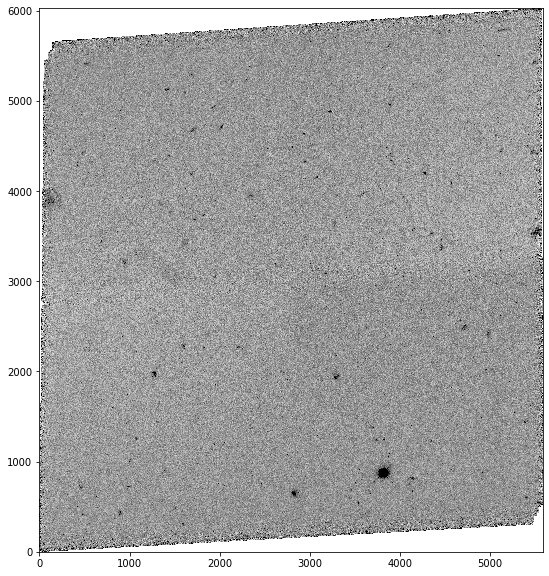

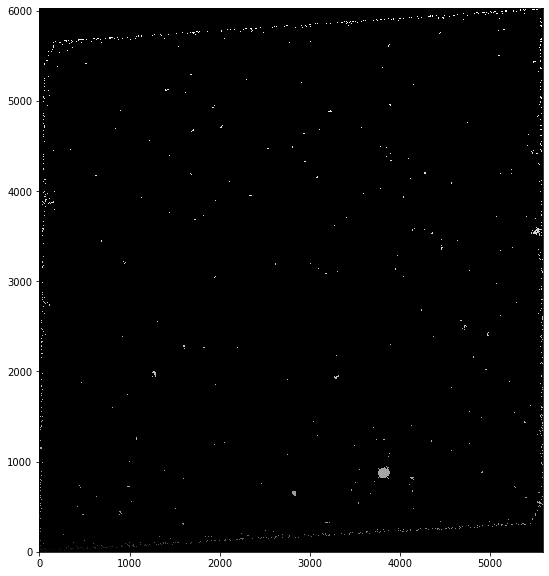

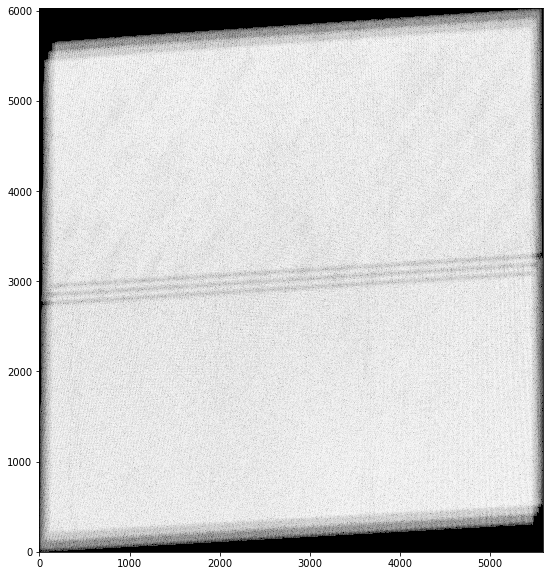

In [6]:
# Plot image
plt.figure(figsize=(10, 10))
# Get image limits for plotting
zscale = ZScaleInterval()
z1, z2 = zscale.get_limits(dat)
plt.imshow(dat, origin='lower', cmap='Greys', vmin=z1, vmax=z2)
plt.show()

# Plot segmenation map
plt.figure(figsize=(10, 10))
imnorm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(segm.data, origin='lower', cmap='Greys_r', norm=imnorm)
plt.show()

# Plot error map
plt.figure(figsize=(10, 10))
imnorm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(ivm, origin='lower', cmap='Greys_r', norm=imnorm)
plt.show()

**4. Measure sky RMS**

Determine an array of RMS measurements from a number (`repeat`) of randomly placed square apertues of pixel size (`ap_size`) on the image, using the the error map to get the image footprint, and the segmentation map to identify where objects are.

In [7]:
def sky_rms(data, err, segm, ap_size=50, repeat=1000):
    '''Function to determine the RMS of the sky background of a drizzled image a large number of times.
    Checks that the randomly placed apertures are in the image footprint and not on an object.
    Requires the input data, corresponding error/IVM map, and segmentation map. Can set the square aperture
    pixel size (ap_size) and the number of repetitions (repeat). Returns a list of RMS values from sky
    background of the image.'''

    # Determines data size
    y, x = data.shape
    random.seed(16483)

    # Set starting values
    good=0
    bad=0
    rms_vals = []
    
    # Loop to randomly place apertures on the image
    while good<repeat:
        # Get a random placement of aperture on the drizzle image
        start = [random.randint(0,(y-ap_size)), random.randint(0,(x-ap_size))]

        # Define the pixels over this image of the err map (to check if in the image footprint)
        err_pix = err[start[0]:start[0]+ap_size, start[1]:start[1]+ap_size]
        
        # Check there are no objects in this footprint 
        seg_pix = segm[start[0]:start[0]+ap_size, start[1]:start[1]+ap_size]

        # If the aperture is within the footprint and has no objects in, take and store the RMS of the data
        if np.all(err_pix != 0) and np.all(seg_pix == 0):
            
            # Set the data in the aperture
            ap_dat = data[start[0]:start[0]+ap_size, start[1]:start[1]+ap_size]
            
            # Determine the RMS within the sky aperture
            rms = np.sqrt(np.nanmean(ap_dat**2))
            rms_vals.append(rms)
            # print(rms)
            
            # Counts the number of good apertures placed, loop runs until this number reaches the `repeat` value
            good+=1
        
        else:
            bad+=1

    print('Good apertures: {}, bad apertures: {}'.format(good, bad))
    
    return rms_vals

In [8]:
# Get array of RMS values measured from image
rms_vals = sky_rms(dat, ivm, segm.data, ap_size=50, repeat=1000)

Good apertures: 1000, bad apertures: 136


**5. Plot histogram of RMS values**

Plot histogram and Gaussian distribution of RMS values, and determine statistics.

In [9]:
def plot_hist_gauss(rms, label='', col='b', sig_clip=3.0, nbins='auto', normpdf=True):
    """Determines sigma-clipped stats (sig_clip) of the input values, plots a histogram 
    of the values either normalized (normpdf=True) or not with user-defined bins (nbins, default 'auto'). 
    Then overplots a Gaussian and mean line (with value given) all of user-specified color string (col) 
    and label (label)."""
    
    # Sigma-clipped stats for best fit of data
    mu, med, std = sigma_clipped_stats(rms, sigma=sig_clip)
    print("{}-sigma-clipped stats: mu={}, med={}, std={}".format(sig_clip, mu, med, std))

    # Determine the histogram of the RMS values
    if normpdf==True: n, bins, patches = plt.hist(rms, bins=nbins, density=True, stacked=True, histtype='step', label=r"{}, avg. RMS: %.6f".format(label) % (mu), color=col)
    else: n, bins, patches = plt.hist(rms, bins=nbins, density=False, histtype='step', label=r"{}, avg. RMS: %.6f".format(label) % (mu), color=col)
    
    # Add a 'best fit' Gaussian line
    y = norm.pdf(bins, mu, std)
    if normpdf==True: 
        l = plt.plot(bins, y, color=col, ls='--', linewidth=1.5)
        plt.ylabel('Density')
    else:
        #Scale the Gaussian if not normalized
        dx = bins[1]-bins[0]
        scale = len(rms)*dx
        l = plt.plot(bins, y*scale, color=col, ls='--', linewidth=1.5)
        plt.ylabel('Frequency')
    
    # Plot the mean as a vertical line
    plt.axvline(x=mu, color=col)
    plt.xlabel('RMS of Sky Background')
    
    plt.legend()
    
    return mu, med, std

3.0-sigma-clipped stats: mu=0.00038879088242538273, med=0.00038619613042101264, std=2.8700673283310607e-05


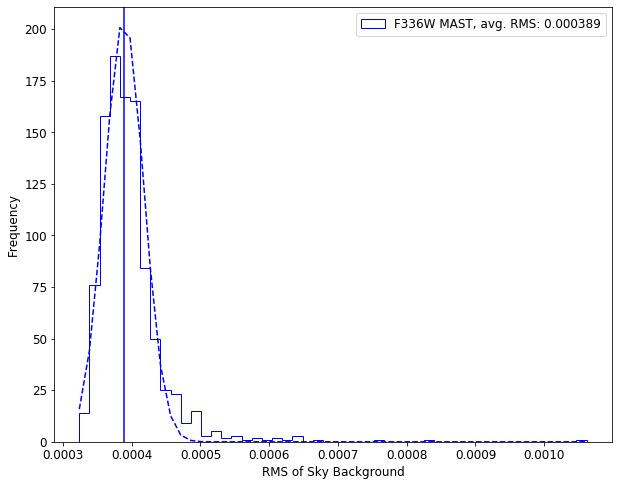

In [10]:
# Set plot params
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})

# Plot RMS histograms, gaussians, and get averages
mu, med, std = plot_hist_gauss(rms_vals, label='F336W MAST', col='b', sig_clip=3.0, nbins=50, normpdf=False)

# # Save plot
# plt.tight_layout()
# plt.savefig("sky_rms_hist.png", dpi=200)

_________________________________
**Optional: Convert the average RMS to a limiting magnitude**

The following requires more user input depending on the filter of the image and desired aperture size for your photometry. First determine the AB magnitude zeropoint of the filter (e.g. from the [WFC3 cal webpages](https://www.stsci.edu/hst/instrumentation/wfc3/data-analysis/photometric-calibration/uvis-photometric-calibration) or other instrument), get the pixel scale in arcsec from the drizzle header (this may have a different keyword), and set the desired aperture size (diameter of a circular aperture) for your photometry in arcseconds.

In [12]:
# ---------------------------------------
# REQUIRED USER INPUTS

# Zeropoint AB magnitude for F336W
zeropoint = 24.708

# Get pixel size from header in arcsec
pix_scale = hdr['D001SCAL']

# Set aperture size in arcsec
ap_arcsec = 1.
# ---------------------------------------

# Calculate the circular aperture size in pixels
ap_area_pix = np.pi*(0.5*(ap_arcsec/pix_scale))**2

# Determine the avg. RMS sky background in the aperture 
ap_rms_sum = mu*ap_area_pix

# Determine the magnitude of the average background RMS in the aperture size
ap_rms_sum_mag = -2.5*np.log10(ap_rms_sum) + zeropoint

print('Limiting AB magnitude in a {} arcsec diameter circular aperture: {}'.format(ap_arcsec, ap_rms_sum_mag))

Limiting AB magnitude in a 1.0 arcsec diameter circular aperture: 25.88159139095916
